<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import clear_output

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

In [3]:
!unzip /content/drive/MyDrive/ColabNotebooks/faces_dataset_small.zip

Archive:  /content/drive/MyDrive/ColabNotebooks/faces_dataset_small.zip
   creating: faces_dataset_small/
  inflating: faces_dataset_small/00055.png  
  inflating: faces_dataset_small/00237.png  
  inflating: faces_dataset_small/00240.png  
  inflating: faces_dataset_small/00241.png  
  inflating: faces_dataset_small/00242.png  
  inflating: faces_dataset_small/00243.png  
  inflating: faces_dataset_small/00244.png  
  inflating: faces_dataset_small/00245.png  
  inflating: faces_dataset_small/00246.png  
  inflating: faces_dataset_small/00247.png  
  inflating: faces_dataset_small/00248.png  
  inflating: faces_dataset_small/00249.png  
  inflating: faces_dataset_small/00253.png  
  inflating: faces_dataset_small/00255.png  
  inflating: faces_dataset_small/00257.png  
  inflating: faces_dataset_small/00258.png  
  inflating: faces_dataset_small/00259.png  
  inflating: faces_dataset_small/00260.png  
  inflating: faces_dataset_small/00261.png  
  inflating: faces_dataset_small/00262.

In [4]:
DATA_DIR = '/content/faces_dataset'
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
def get_dataloader(data_dir, image_size, batch_size, stats):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  
  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
  
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

  return train_dl

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [7]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

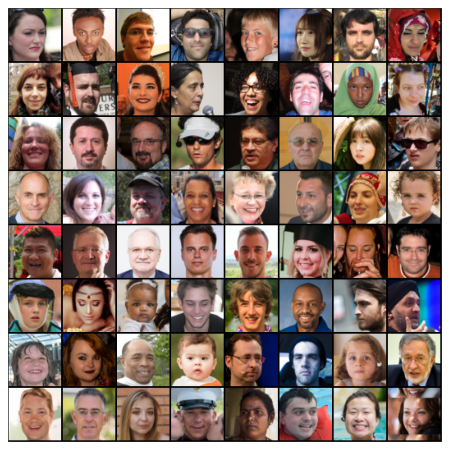

In [10]:
image_size = 64
batch_size = 128

train_dl = get_dataloader(DATA_DIR, image_size, batch_size, stats)
show_batch(train_dl)

In [11]:
#TODO: build dataloader and transfer it to device
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

 Stride is the number of pixels shifts over the input matrix. 
 For padding p, filter size 𝑓∗𝑓 and input image size 𝑛 ∗ 𝑛 
 and stride ‘𝑠’ our output image dimension will be 
 [ {(𝑛 + 2𝑝 − 𝑓) / 𝑠} + 1] ∗ [ {(𝑛 + 2𝑝 − 𝑓) / 𝑠} + 1]

In [12]:
discriminator = nn.Sequential(
    # in: 3 x 512 x 512

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    
#     nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 16 x 16
    
#     nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
    # out: 2048 x 8 x 8
    
#     nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
    # out: 4096 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [13]:
discriminator = to_device(discriminator, device)

In [14]:
latent_size = 512 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

#     nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
    # out: 4096 x 4 x 4

#     nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
    # out: 2048 x 8 x 8

#     nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
    # out: 1024 x 16 x 16

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [15]:
generator = to_device(generator, device)

torch.Size([128, 3, 64, 64])


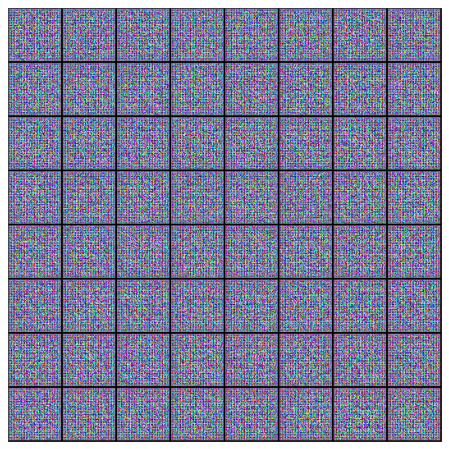

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb.cuda())
print(fake_images.shape)
show_images(fake_images.cpu())

In [16]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [17]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [18]:
def save_samples(model, index, latent_tensors, show=True):
    fake_images = model["generator"](latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [19]:
def fit(model, criterion, epochs, lr):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), #AdamW
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    # Create sheduler
    scheduler = {
        "discriminator": torch.optim.lr_scheduler.MultiStepLR(optimizer["discriminator"], 
                                                              milestones=[50, 150, 280], gamma=0.5), #  milestones=[50, 100, 150, 280], gamma=0.5)
        "generator": torch.optim.lr_scheduler.MultiStepLR(optimizer["generator"], 
                                                          milestones=[50, 150, 280], gamma=0.5)
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            real_images = real_images.cuda()
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=torch.device('cuda'))
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=torch.device('cuda'))
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=torch.device('cuda'))
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=torch.device('cuda'))
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=torch.device('cuda'))
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        if scheduler:
            scheduler["discriminator"].step()
            scheduler["generator"].step()

        # visualize        
        clear_output(wait=True)
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        
        xb = torch.randn(batch_size, latent_size, 1, 1) 
        fake_images = model['generator'](xb.cuda())
        show_images(fake_images.cpu())
        
        plt.figure(figsize=(15, 6))
        plt.plot(losses_d, '-')
        plt.plot(losses_g, '-')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['Discriminator', 'Generator'])
        plt.title('Losses')
        
        plt.figure(figsize=(15, 6))
        plt.plot(real_scores, '-')
        plt.plot(fake_scores, '-')
        plt.xlabel('epoch')
        plt.ylabel('score')
        plt.legend(['Real', 'Fake'])
        plt.title('Scores');
        plt.show()
        
        # Save generated images
#         if epoch == epochs - 1:
#             save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [20]:
lr = 1e-3
epochs = 140 #300 эпох дают более красивый результат

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

Epoch [132/140], loss_g: 5.2815, loss_d: 0.1298, real_score: 0.9442, fake_score: 0.0535


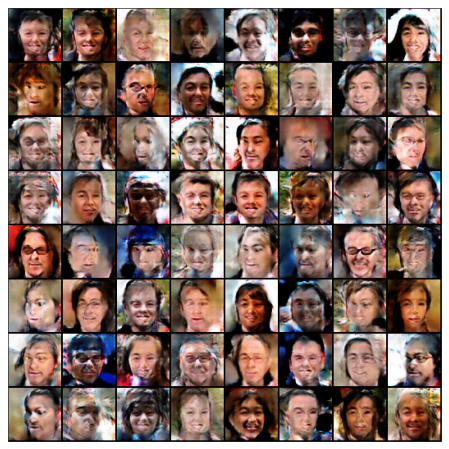

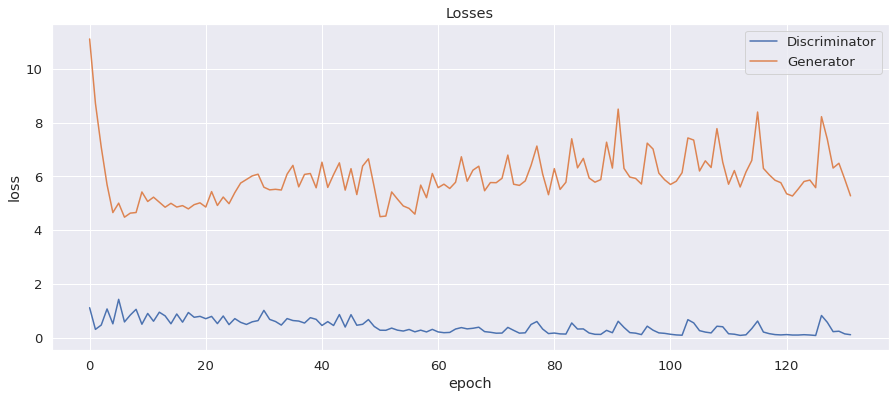

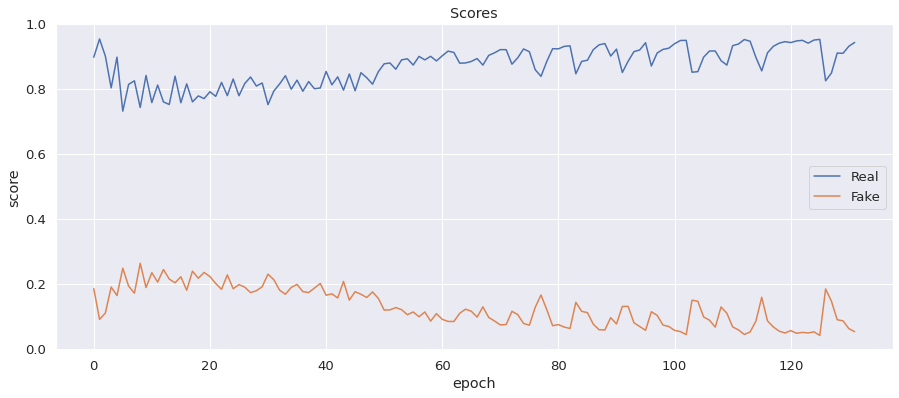

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
history = fit(model, criterion, epochs, lr)

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

torch.save(model['generator'].state_dict(), '/content/drive/MyDrive/ColabNotebooks/generator_e300_png64_l512.pth')
torch.save(model['discriminator'].state_dict(), '/content/drive/MyDrive/ColabNotebooks/discriminator_e300_png64_l512.pth')

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
fake_images = model["generator"](fixed_latent.cuda())
show_images(fake_images.cpu())

Как вам качество получившихся изображений?

Классно!

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, cross_val_score

Считать knn на 16k параметрах не будем, так как:

* это занимает много времени
* метрические алгоритмы подвержены проклятью размерности

Выделим главные компоненты методом PCA. Оставим n главных компонент, объсяющих 90% дисперсии.

In [ ]:
fixed_latent = torch.randn(500, latent_size, 1, 1, device=torch.device('cuda'))
fake_images = model["generator"](fixed_latent)
fake_images = fake_images.detach().cpu().flatten(start_dim=1)

In [ ]:
# загрузим реальные изображения 64х64
dl = get_dataloader(DATA_DIR, image_size, 500, stats)

for batch, _ in dl:
    true_images = batch
    break

true_images = true_images.flatten(start_dim=1)

In [ ]:
true_images.shape

In [ ]:
fake_images.shape

In [ ]:
# обучющая выборка
X = torch.cat((fake_images, true_images))

In [ ]:
# таргеты
y0 = torch.zeros(fake_images.shape[0])
y1 = torch.ones(true_images.shape[0])
y = torch.cat((y0, y1))

In [ ]:
pca = PCA(n_components=0.9)

X_transformed = pca.fit_transform(X)

In [ ]:
# число главных компонент
len(pca.explained_variance_ratio_)

In [ ]:
def plot_variances(d_variances):
    n_components = np.arange(1,d_variances.size+1)
    plt.plot(n_components, d_variances, 'b', label='Component variances')
    plt.xlim(n_components[0], n_components[-1])
    plt.xlabel('n components')
    plt.ylabel('variance')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
plot_variances(pca.explained_variance_)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()

In [ ]:
scores = cross_val_score(knn, X_transformed, y, scoring='accuracy', cv=loo, n_jobs=-1)

In [ ]:
# accuracy
scores.mean()

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Желаемый результат - 0.5. Мы хотим, чтобы реальные изображения были неотличимы от сгенерированных.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

Прокомментируйте получившийся результат:

In [ ]:
tsne = TSNE(n_jobs=-1)

In [ ]:
true_images_tsne = tsne.fit_transform(true_images)

In [ ]:
fake_images_tsne = tsne.fit_transform(fake_images)

In [ ]:
images_tsne = np.concatenate((fake_images_tsne, true_images_tsne))

In [ ]:
plt.figure(figsize=(18, 18))
sns.scatterplot(x=images_tsne[:, 0], y=images_tsne[:, 1], hue=y)
plt.show()

На графике видно, что реальные и сгенерированные изображения перемешаны в пространстве $R^2$; однако, фейковые изображения имеют большую дисперсию. По краям много сгенерированных изображений сильно отличающихся от реальных (плохого качества). Хорошо сгенерированные картинки - те, что находятся в области реальных изображений. Но из-за высокой разреженности их немного.